In [4]:
import sklearn
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from wordcloud import WordCloud


import tensorflow as tf
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences
from keras._tf_keras.keras.layers import Embedding , LSTM ,Dense,Dropout
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.preprocessing.text import one_hot,Tokenizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# Veri Ön İşleme

In [ ]:
dogru_haber_df = pd.read_csv("dogru_haberler.csv")
sahte_haber_df = pd.read_csv("sahte_haberler.csv")


dogru_haber_sayisi = dogru_haber_df.shape[0]
yanlis_haber_sayisi = sahte_haber_df.shape[0]

islenmis_dogru_haberler = []
islenmis_sahte_haberler = []
stopWords = []
with open("stopWords.txt","r") as file :
    for satir in file:
        satir=satir.strip().lower()
        if len(satir)>1:
            stopWords.append(satir)

for i in range(dogru_haber_sayisi):
    # dogru haber dosyasındaki verileri teker teker alıyoruz 
    metin = dogru_haber_df.iloc[i,0]
    # metini kelimlere böldük
    kelimeler = metin.split()
    # stopWord kelimleri metinden çıkardık 
    kelimeler += [kelime for kelime in kelimeler if kelime not in stopWords]
    # join ile kelimeler listesini boşluk karakteri koyarak birleştirdik
    cumle = ' '.join(kelimeler)
    # islenmiş olarak listeye ekledik 
    islenmis_dogru_haberler.append(cumle)

for i in range(yanlis_haber_sayisi):
    metin = sahte_haber_df.iloc[i,0]
    kelimeler = metin.split()
    kelimeler = [kelime for kelime in kelimeler if kelime not in stopWords]
    cumle = ' '.join(kelimeler)
    islenmis_sahte_haberler.append(cumle)

islenmis_dogru_haberler_df = pd.DataFrame(islenmis_dogru_haberler,columns=["Haber"])
islenmis_sahte_haberler_df = pd.DataFrame(islenmis_sahte_haberler,columns=["Haber"])

islenmis_dogru_haberler_df.to_csv("islenmis_dogru_haberler.csv",index=False)
islenmis_sahte_haberler_df.to_csv("islenmis_sahte_haberler.csv",index=False)

# Csv dosyasından veri çekme 


In [5]:
real = pd.read_csv("islenmis_dogru_haberler.csv")
fake = pd.read_csv("islenmis_sahte_haberler.csv")


real['label'] = 1
fake['label'] = 0


df = pd.concat([real, fake], ignore_index=True)
X = df["Haber"]
y = df['label']


# veri setini egitim ve test veri seti olarak bolduk 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)



# Word Cloud Doğru Haberler



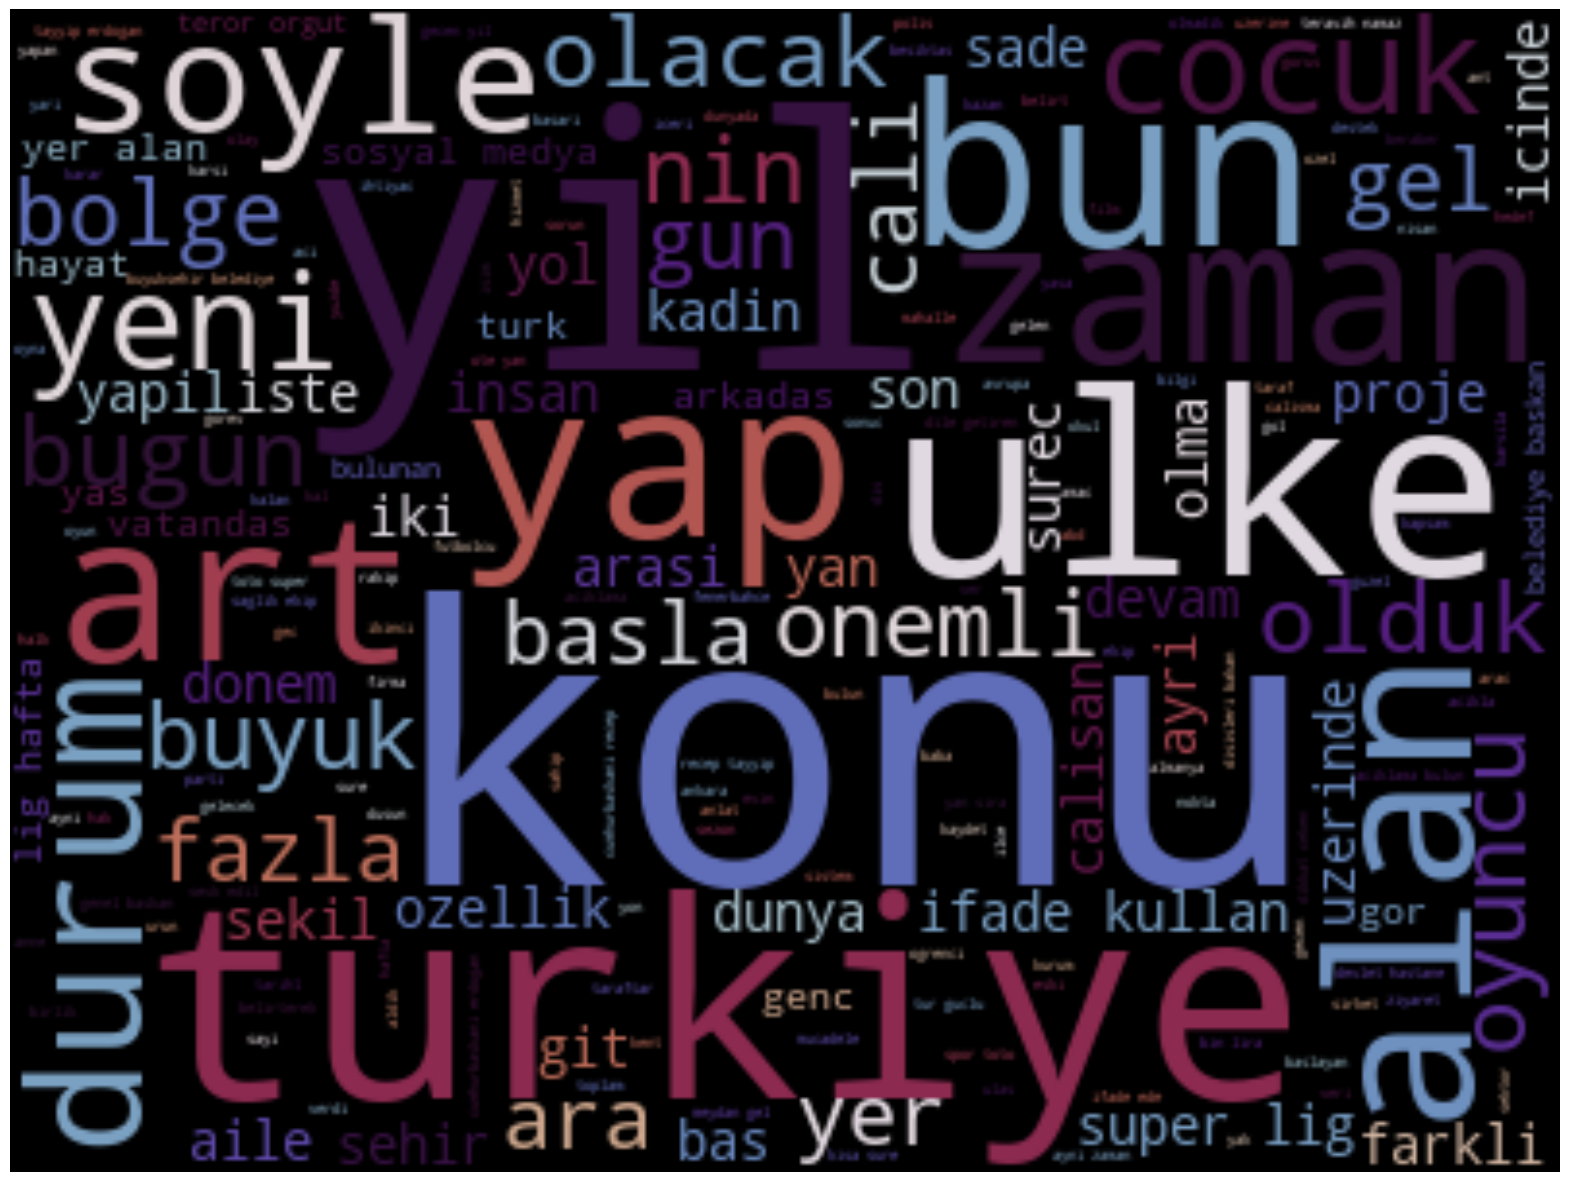

In [11]:
sentence = []
for i in real["Haber"]:
    sentence.append(i)
    
text_ = " ".join(map(str, sentence)) 

wordcloud = WordCloud(width = 400, 
                      height = 300, 
                      max_font_size = 100, 
                      colormap = "twilight_shifted").generate(text_)

plt.figure(figsize = (20,17))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# Word Cloud Yalan Haberler

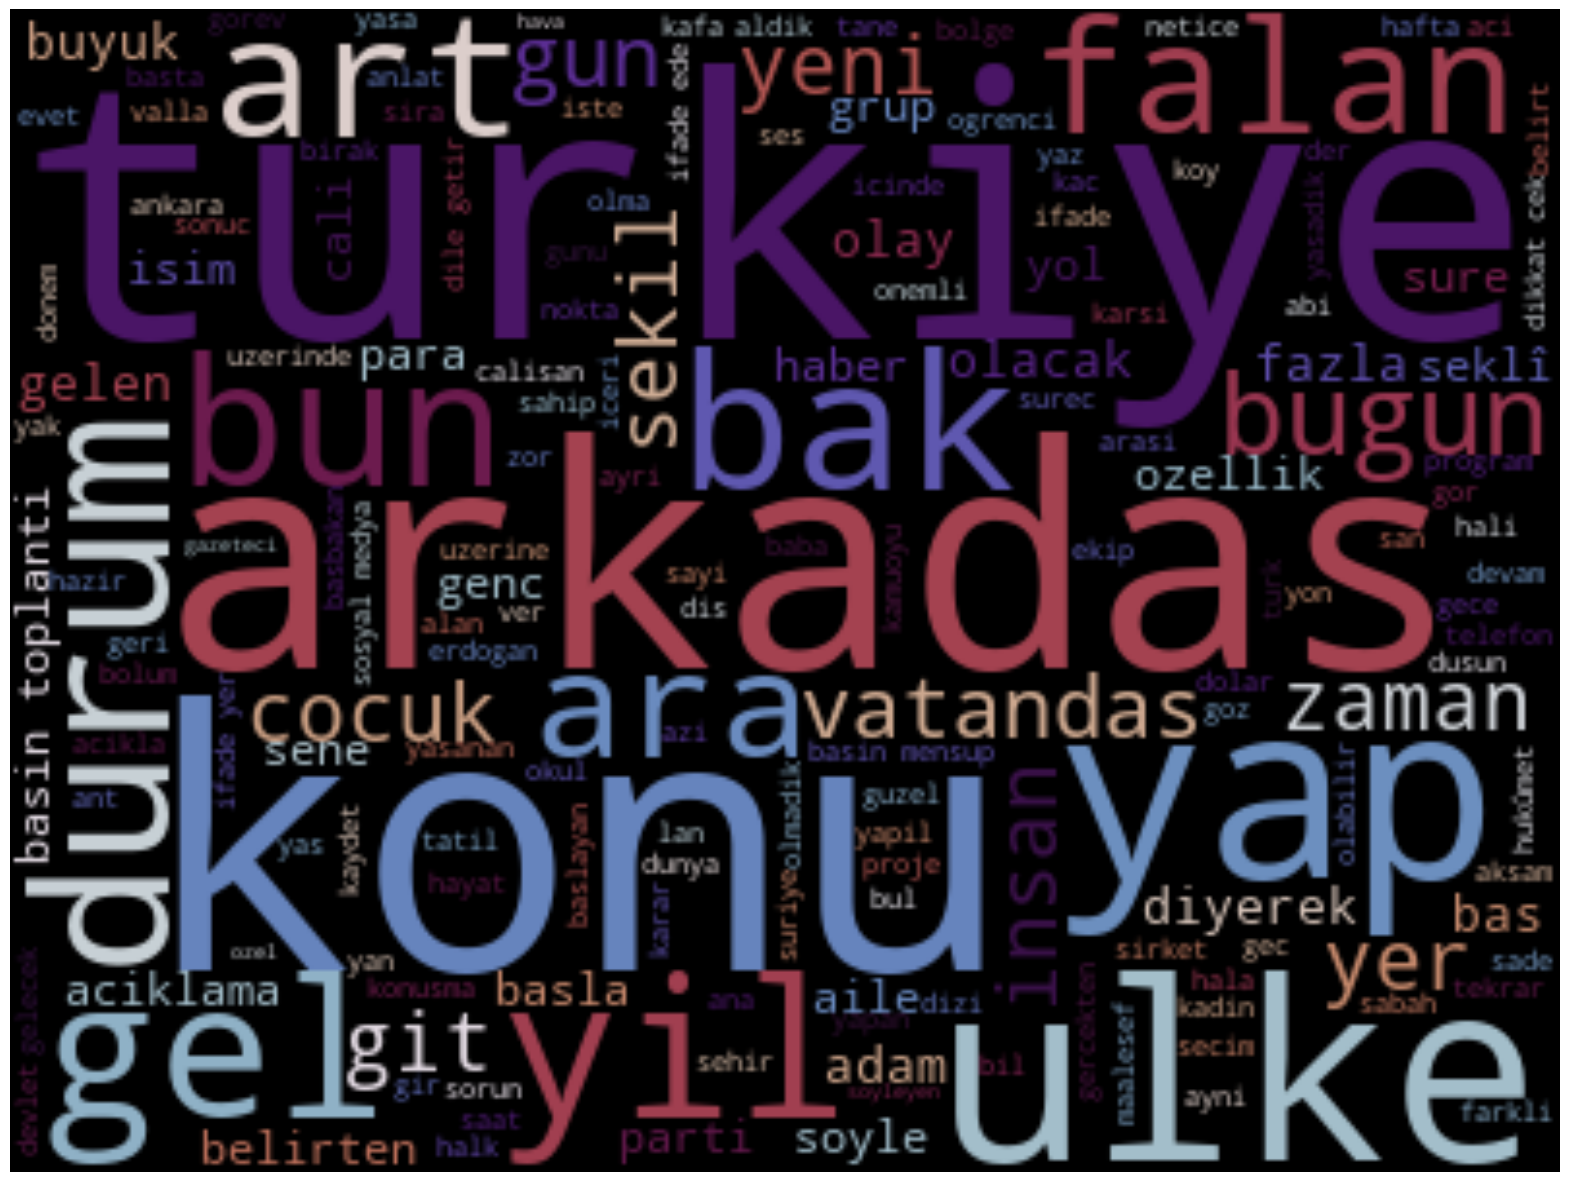

In [14]:
sentence = []

for i in fake["Haber"]:
    sentence.append(i)
    
text_ = " ".join(map(str, sentence)) 

wordcloud = WordCloud(width = 400, 
                      height = 300, 
                      max_font_size = 100, 
                      colormap = "twilight_shifted").generate(text_)

plt.figure(figsize = (20,17))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# Word2Vec

In [16]:
EMBEDDING_DIM = 200 # Her kelime bu boyuttaki bir vektörle temsil edilecek 
w2v_train = list(map(lambda x: x.split(), X_train))
w2v_model = Word2Vec(sentences=w2v_train, vector_size=EMBEDDING_DIM, window=5, workers = 4, min_count=5)
# window kelimelerin bağlamına bakar 5 kelime otesi ve ardındaki kelimler ile ilişkisine bakar 
# workers işlem yapılırken paralel olarak çalışacak thread sayısını belirtir 


# TF-IDF 

# FastText 

# Bert 

# Tokeneizer

In [17]:
vocab_length = 50000 # metinlerin içersinde kullanılan en sık kelimeler 50.000 tanesini ele alır . Yani en sık kullanılan 50.000 kelimeye dikkat edilir. 

tokenizer = Tokenizer(filters="", lower=False, oov_token="")
tokenizer.fit_on_texts(X_train)
tokenizer.num_words = vocab_length

input_len = 1000

# Metin verilerini sayısal dizilere dönüştürür  ve sabit bir uzunluğa kadar doldurur. 
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_len) # X_train içindeki metin verilerini sayısal diziye dönüşütürür 
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_len) # pad_sequences ile metin verilerine maxlen parametresiyle bir boyut verilir.

embedding_matrix = np.zeros((vocab_length, EMBEDDING_DIM))

for word, token in tokenizer.word_index.items():
    if w2v_model.wv.__contains__(word):
        embedding_matrix[token] = w2v_model.wv.__getitem__(word)

# Model Oluşturma 

In [18]:
model=Sequential()
model.add(Embedding(input_dim = vocab_length,#
                    output_dim = EMBEDDING_DIM,#
                    weights = [embedding_matrix],
                    input_length = input_len,
                    trainable = False))
model.add(LSTM(100, dropout=0.2)) # lstm neuron size
model.add(Dense(1,activation='sigmoid')) # dense layer, activation function
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,000,000 (38.15 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,000,000 (38.15 MB)

None


# Model Eğitim

In [8]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)
# batch_size : model eğitilirken kullanılcak örnek sayısını belirtir .
# validation_split : her bir epoch adımında eğitim veri setindaki %20'lik kısmını doğruluk değerini hesaplaması için ayırmamızdır.
# bu parametre overfitting veya underfitting olaylarını kontrol etmememiz için kullanılır .

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 864ms/step - accuracy: 0.7520 - loss: 0.5022 - val_accuracy: 0.8952 - val_loss: 0.2985
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 874ms/step - accuracy: 0.8831 - loss: 0.3223 - val_accuracy: 0.9162 - val_loss: 0.2475
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 912ms/step - accuracy: 0.9049 - loss: 0.2868 - val_accuracy: 0.9117 - val_loss: 0.2820
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 923ms/step - accuracy: 0.8870 - loss: 0.3018 - val_accuracy: 0.9132 - val_loss: 0.2395
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 984ms/step - accuracy: 0.8909 - loss: 0.2812 - val_accuracy: 0.8997 - val_loss: 0.2886
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9002 - loss: 0.2823 - val_accuracy: 0.9281 - val_loss: 0.2346
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9194 - loss: 0.2394 - val_accuracy: 0.9371 - val_loss: 0.2040
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 987ms/step - accuracy: 0.9274 - loss: 0.2229 - val_accuracy: 

# Model Değerlendirme

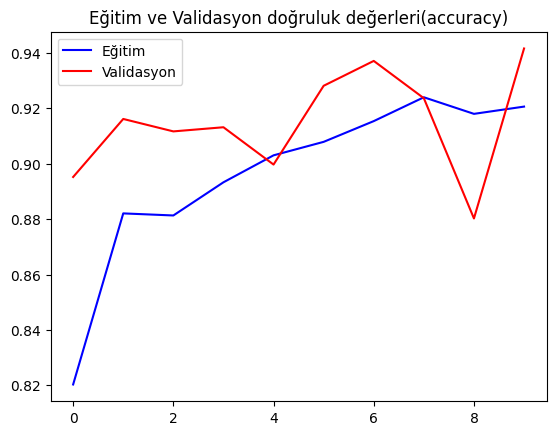

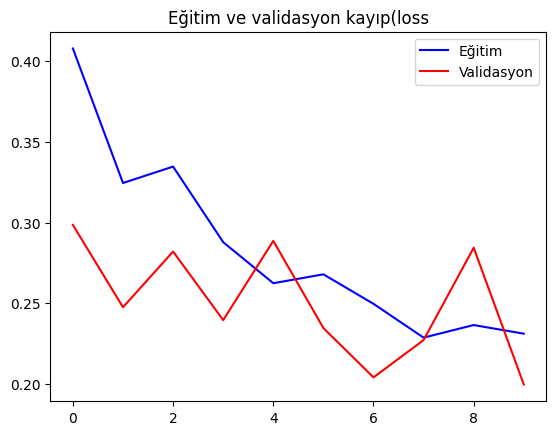

In [9]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Eğitim')
plt.plot(epochs, val_acc, 'r', label='Validasyon')
plt.title('Eğitim ve Validasyon doğruluk değerleri(accuracy)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Eğitim')
plt.plot(epochs, val_loss, 'r', label='Validasyon')
plt.title('Eğitim ve validasyon kayıp(loss')
plt.legend()


# Tahmin Yapılması

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step
Test Verisi doğruluk değeri: 90.4


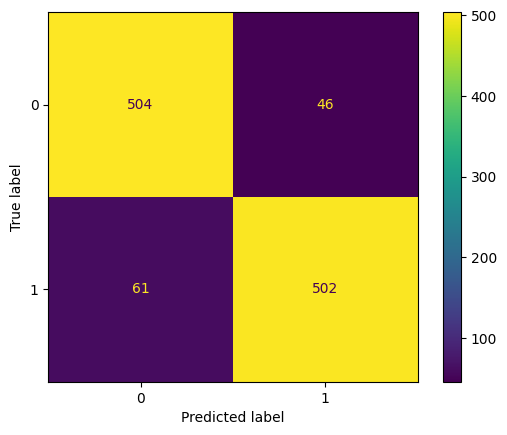

In [12]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

accuracy = accuracy_score(y_test,y_pred)
print('Test Verisi doğruluk değeri: %.1f'%(accuracy*100))

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()